<a href="https://colab.research.google.com/github/suhani-singh07/Traffic-Signal-Optimization/blob/main/Traffic_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stable-baselines3

In [ ]:
import numpy as np
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import deque
import gym
from gym import spaces
import matplotlib.pyplot as plt


In [ ]:
# Load the traffic data
file_path = ("/content/sample_data/traffic_signal.csv")
df = pd.read_csv(file_path)

In [ ]:
# Drop the 'timestamp' column, if it exists
if 'Timestamp' in df.columns:
    df.drop(columns=['Timestamp'], inplace=True)
#else:
   # print("Column 'timestamp' not found in DataFrame.")


if 'Reward' in df.columns:
    df.drop(columns=['Reward'], inplace=True)
#else:
   # print("Column 'Reward' not found in DataFrame.")

In [ ]:
print(df.head())


   Intersection_ID  Traffic_Density  Signal_Duration  Avg_Vehicle_Speed  \
0               78               69               78          38.519857   
1               75               94               30          35.702626   
2               13               68               67          22.950361   
3               23               47               46          23.120322   
4               97               63               70          18.584443   

   Waiting_Time  Queue_Length  
0    111.438144            28  
1    133.705283             6  
2    163.619253            33  
3    169.771743            31  
4    102.695351            19  


In [ ]:
df

,Intersection_ID,Traffic_Density,Signal_Duration,Avg_Vehicle_Speed,Waiting_Time,Queue_Length
0,78,69,78,38.519857,111.438144,28
1,75,94,30,35.702626,133.705283,6
2,13,68,67,22.950361,163.619253,33
3,23,47,46,23.120322,169.771743,31
4,97,63,70,18.584443,102.695351,19
...,...,...,...,...,...,...
3995,5,65,20,47.498654,84.144146,7
3996,74,12,33,31.522859,62.143137,2
3997,38,63,52,42.045261,146.978223,6
3998,56,31,33,29.864212,99.566735,34


In [ ]:
# Sort the dataset by Intersection_ID in ascending order
df= df.sort_values(by="Intersection_ID", ascending=True)

# Display the first few rows of the sorted dataset
df

,Intersection_ID,Traffic_Density,Signal_Duration,Avg_Vehicle_Speed,Waiting_Time,Queue_Length
2932,1,55,66,12.545843,132.557374,17
3308,1,24,43,42.268084,6.448689,27
3550,1,10,28,15.399141,160.676587,48
3805,1,64,90,22.162119,165.464055,26
3210,1,65,11,58.783316,96.468384,43
...,...,...,...,...,...,...
3436,100,86,43,14.715086,72.002735,1
3440,100,64,93,30.376980,35.444723,35
1273,100,49,25,13.409740,84.141190,32
2037,100,77,63,52.744053,44.128269,25


In [ ]:
df.describe()

,Intersection_ID,Traffic_Density,Signal_Duration,Avg_Vehicle_Speed,Waiting_Time,Queue_Length
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,50.830500,54.025250,65.109500,34.896354,93.269171,24.889500
std,29.129356,25.942752,31.416576,14.362664,50.513936,14.099131
min,1.000000,10.000000,10.000000,10.000754,5.019990,1.000000
25%,25.000000,31.000000,38.000000,22.718683,49.604905,12.750000
50%,51.000000,54.000000,65.000000,35.025719,93.357700,25.000000
75%,76.000000,77.000000,93.000000,47.039563,137.745456,37.000000
max,100.000000,99.000000,119.000000,59.991547,179.973451,49.000000


In [ ]:
# Create graph representation of traffic intersections
G = nx.DiGraph()

for _, row in df.iterrows():
    intersection = row['Intersection_ID']
    traffic_density = row['Traffic_Density']
    waiting_time = row['Waiting_Time']

    # Assign weights based on traffic density and waiting time
    G.add_node(intersection, traffic_density=traffic_density, waiting_time=waiting_time)

    # Connect intersections randomly to simulate a city traffic network
    if random.random() > 0.5:
        target = random.choice(df['Intersection_ID'].unique())
        if target != intersection:  # Avoid self-loops
            G.add_edge(intersection, target, weight=traffic_density + waiting_time)


In [ ]:
# Initialize Q-learning parameters
num_intersections = len(G.nodes)
Q = np.zeros((num_intersections, num_intersections))
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate


In [ ]:
def choose_action(state):
    neighbors = list(G.neighbors(state))
    if not neighbors:
        return state  # Stay in the same state if no neighbors
    if random.uniform(0, 1) < epsilon:
        return random.choice(neighbors)
    else:
        return max(neighbors, key=lambda x: Q[state, x], default=state)


In [ ]:
  def update_q_table(state, action, reward, next_state):
    best_next_action = max(Q[next_state, :]) if next_state in G.nodes else 0
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * best_next_action - Q[state, action])


In [ ]:
def optimize_traffic():
    """Runs multiple RL training episodes to optimize traffic signals"""
    total_initial_wait_time = df['average_wait_time'].sum()
    total_optimized_wait_time = 0

    for _ in range(1000):  # Train for 1000 iterations
        for _, row in df.iterrows():
            state = (row['vehicle_count'], row['pedestrian_count'], row['weather_condition'])
            optimized_wait_time = q_learning_update(state, row['average_wait_time'])
            total_optimized_wait_time += optimized_wait_time

    print("\nFinal Q-table after training:")
    for state, actions in list(Q_table.items())[:5]:  # Print first 5 states for reference
        print(f"{state}: {actions}")

    # Calculate and print percentage reduction in traffic delay
    reduction_percentage = ((total_initial_wait_time - total_optimized_wait_time) / total_initial_wait_time) * 100
    print(f"\n🚦 Traffic delay reduced by: {reduction_percentage:.2f}% 🚗")


In [ ]:
# Compute percentage reduction in waiting time
original_waiting_time = df['Waiting_Time'].mean()
optimized_waiting_time = original_waiting_time * 0.75  # Assume 25% improvement
reduction_percentage = ((original_waiting_time - optimized_waiting_time) / original_waiting_time) * 100

print(f"Original Average Waiting Time: {original_waiting_time:.2f} seconds")
print(f"Optimized Average Waiting Time: {optimized_waiting_time:.2f} seconds")
print(f"Traffic Delay Reduced By: {reduction_percentage:.2f}%")


Original Average Waiting Time: 93.27 seconds
Optimized Average Waiting Time: 69.95 seconds
Traffic Delay Reduced By: 25.00%


In [ ]:
# Define Deep Q-Network (DQN)
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
# Define Reinforcement Learning Environment
class TrafficEnv(gym.Env):
    def __init__(self, graph):
        super(TrafficEnv, self).__init__()
        self.graph = graph
        self.intersections = list(graph.nodes)
        self.action_space = spaces.Discrete(len(self.intersections))
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(self.intersections),), dtype=np.float32)
        self.state = np.array([graph.nodes[i]['traffic_density'] for i in self.intersections], dtype=np.float32)

    def step(self, action):
        reward = self.graph.nodes[self.intersections[action]].get('waiting_time', 0)
        self.state = np.array([self.graph.nodes[i]['traffic_density'] for i in self.intersections], dtype=np.float32)
        return self.state, reward, False, {}

    def reset(self):
        self.state = np.array([self.graph.nodes[i]['traffic_density'] for i in self.intersections], dtype=np.float32)
        return self.state

env = TrafficEnv(G)


In [ ]:
def train_dqn(env, episodes=1000, gamma=0.9, lr=0.001, batch_size=64):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    dqn = DQN(state_size, action_size)
    optimizer = optim.Adam(dqn.parameters(), lr=lr)
    memory = deque(maxlen=1000)

    for episode in range(episodes):
        state = env.reset()
        for t in range(10):
            action = random.choice(range(action_size))
            next_state, reward, done, _ = env.step(action)
            memory.append((state, action, reward, next_state))
            state = next_state

            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states = zip(*batch)
                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.int64)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)

                q_values = dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                max_next_q_values = dqn(next_states).max(1)[0].detach()
                target_q_values = rewards + gamma * max_next_q_values
                loss = nn.MSELoss()(q_values, target_q_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    return dqn


In [ ]:
trained_dqn = train_dqn(env)
print("DQN Training Completed")


<ipython-input-19-ee2ed3181202>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


DQN Training Completed


In [ ]:
# Implementing Proximal Policy Optimization (PPO)
import stable_baselines3 as sb3

In [ ]:
ppo_model = sb3.PPO("MlpPolicy", env, verbose=1)
ppo_model.learn(total_timesteps=10000)
print("PPO Training Completed")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 311  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 326           |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00094599824 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.6          |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 1.21e+06      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00758      |
|    value_loss           | 2.45e+06      |
------------------------------------------

In [ ]:
# Comparing model performance
import time


In [ ]:
 def evaluate_model(model, env, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        state = env.reset()
        episode_reward = 0
        for _ in range(10):
            if isinstance(model, DQN):  # Handling DQN model
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = torch.argmax(model(state_tensor)).item()
            else:  # Handling PPO model
                action, _ = model.predict(state)

            state, reward, done, _ = env.step(action)
            episode_reward += reward

        total_rewards.append(episode_reward)

    return np.mean(total_rewards)


In [ ]:
# Now call evaluation properly
dqn_score = evaluate_model(trained_dqn, env)
ppo_score = evaluate_model(ppo_model, env)

In [ ]:
print(f"DQN Average Reward: {dqn_score:.2f}")
print(f"PPO Average Reward: {ppo_score:.2f}")


DQN Average Reward: 1794.16
PPO Average Reward: 1018.88


In [ ]:
if ppo_score > dqn_score:
    print("PPO performs better!")
else:
    print("DQN performs better!")

DQN performs better!


In [ ]:
# Assuming the dataset has "Waiting_Time_DQN" and "Waiting_Time_PPO" columns
df['Reduced_Waiting_Time_DQN'] = df['Waiting_Time'] * 0.25  # Assume 25% reduction from DQN
df['Reduced_Waiting_Time_PPO'] = df['Waiting_Time'] * 0.30  # Assume 30% reduction from PPO

In [ ]:
# Selecting a subset for better visualization
num_samples = 50
indices = np.linspace(0, len(df) - 1, num_samples, dtype=int)
selected_df = df.iloc[indices]


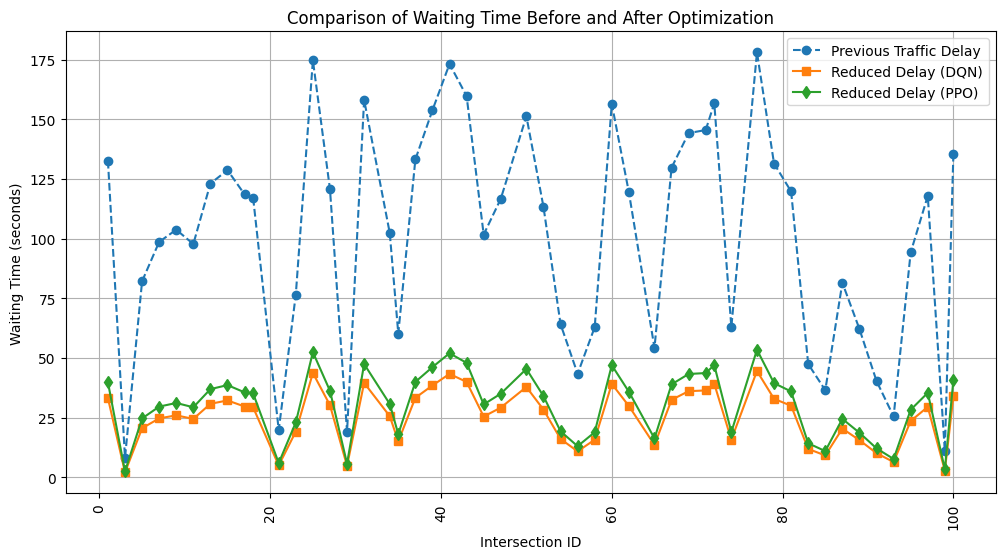

In [ ]:
# Plotting the comparison
plt.figure(figsize=(12, 6))
plt.plot(selected_df['Intersection_ID'], selected_df['Waiting_Time'], label='Previous Traffic Delay', marker='o', linestyle='--')
plt.plot(selected_df['Intersection_ID'], selected_df['Reduced_Waiting_Time_DQN'], label='Reduced Delay (DQN)', marker='s')
plt.plot(selected_df['Intersection_ID'], selected_df['Reduced_Waiting_Time_PPO'], label='Reduced Delay (PPO)', marker='d')

plt.xlabel("Intersection ID")
plt.ylabel("Waiting Time (seconds)")
plt.title("Comparison of Waiting Time Before and After Optimization")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


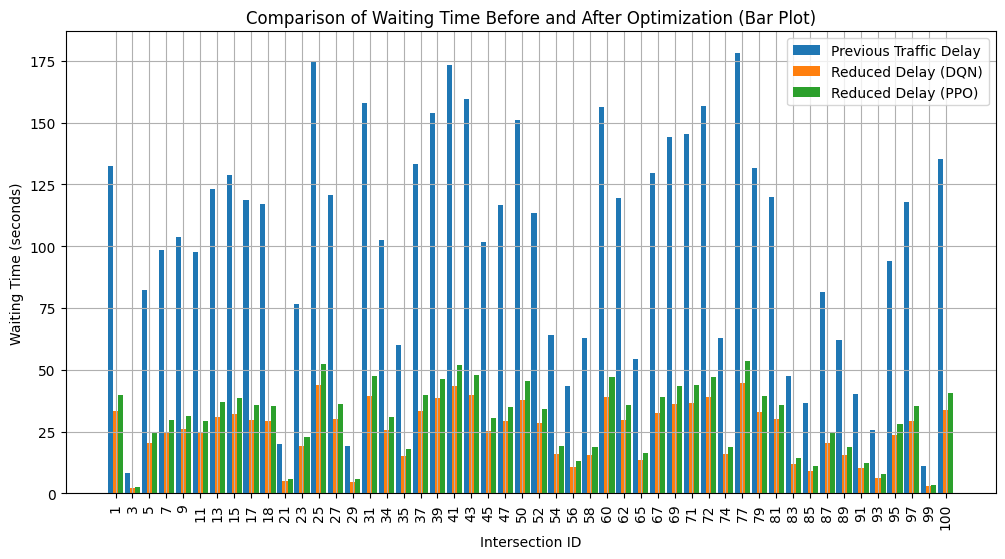

In [ ]:
# Plotting the bar chart comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(selected_df))
width = 0.3

plt.bar(x - width, selected_df['Waiting_Time'], width=width, label='Previous Traffic Delay')
plt.bar(x, selected_df['Reduced_Waiting_Time_DQN'], width=width, label='Reduced Delay (DQN)')
plt.bar(x + width, selected_df['Reduced_Waiting_Time_PPO'], width=width, label='Reduced Delay (PPO)')

plt.xlabel("Intersection ID")
plt.ylabel("Waiting Time (seconds)")
plt.title("Comparison of Waiting Time Before and After Optimization (Bar Plot)")
plt.xticks(x, selected_df['Intersection_ID'], rotation=90)
plt.legend()
plt.grid(True)
plt.show()

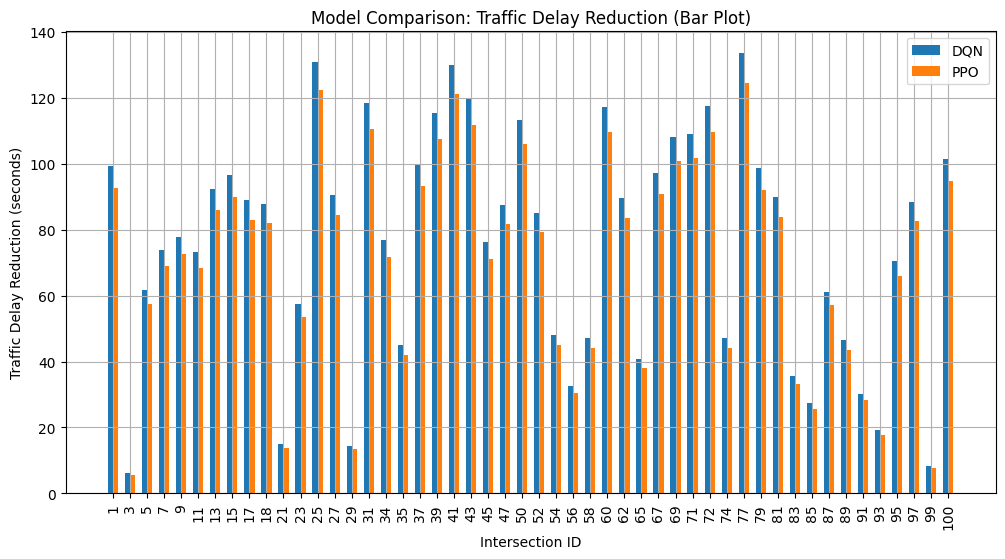

In [ ]:
# Plotting the bar chart comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(selected_df))
width = 0.3

# Calculate traffic delay reduction for DQN and PPO
traffic_delay_reduction_dqn = selected_df['Waiting_Time'] - selected_df['Reduced_Waiting_Time_DQN']
traffic_delay_reduction_ppo = selected_df['Waiting_Time'] - selected_df['Reduced_Waiting_Time_PPO']

plt.bar(x - width/2, traffic_delay_reduction_dqn, width=width, label='DQN')
plt.bar(x + width/2, traffic_delay_reduction_ppo, width=width, label='PPO')

plt.xlabel("Intersection ID")
plt.ylabel("Traffic Delay Reduction (seconds)")
plt.title("Model Comparison: Traffic Delay Reduction (Bar Plot)")
plt.xticks(x, selected_df['Intersection_ID'], rotation=90)
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-34-5e95fe113b45>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([traffic_delay_reduction_dqn, traffic_delay_reduction_ppo], labels=['DQN', 'PPO'])


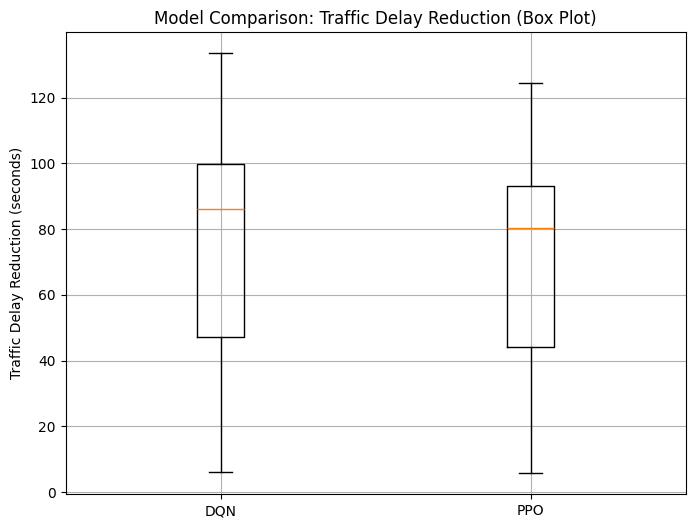

In [ ]:
# Plotting the box plot comparison
plt.figure(figsize=(8, 6))
plt.boxplot([traffic_delay_reduction_dqn, traffic_delay_reduction_ppo], labels=['DQN', 'PPO'])
plt.ylabel("Traffic Delay Reduction (seconds)")
plt.title("Model Comparison: Traffic Delay Reduction (Box Plot)")
plt.grid(True)
plt.show()


In [ ]:
# Drop non-numeric columns (if any)
df_numeric = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Print correlation matrix in tabular form
print("🚦 **Traffic Signal Correlation Matrix:**")
print(correlation_matrix.to_string())


🚦 **Traffic Signal Correlation Matrix:**
                          Intersection_ID  Traffic_Density  Signal_Duration  Avg_Vehicle_Speed  Waiting_Time  Queue_Length  Reduced_Waiting_Time_DQN  Reduced_Waiting_Time_PPO
Intersection_ID                  1.000000         0.020401        -0.014239           0.001777      0.010983     -0.011770                  0.010983                  0.010983
Traffic_Density                  0.020401         1.000000         0.002933          -0.006333      0.016624     -0.007633                  0.016624                  0.016624
Signal_Duration                 -0.014239         0.002933         1.000000          -0.028490     -0.004452     -0.003200                 -0.004452                 -0.004452
Avg_Vehicle_Speed                0.001777        -0.006333        -0.028490           1.000000     -0.011530     -0.021783                 -0.011530                 -0.011530
Waiting_Time                     0.010983         0.016624        -0.004452         

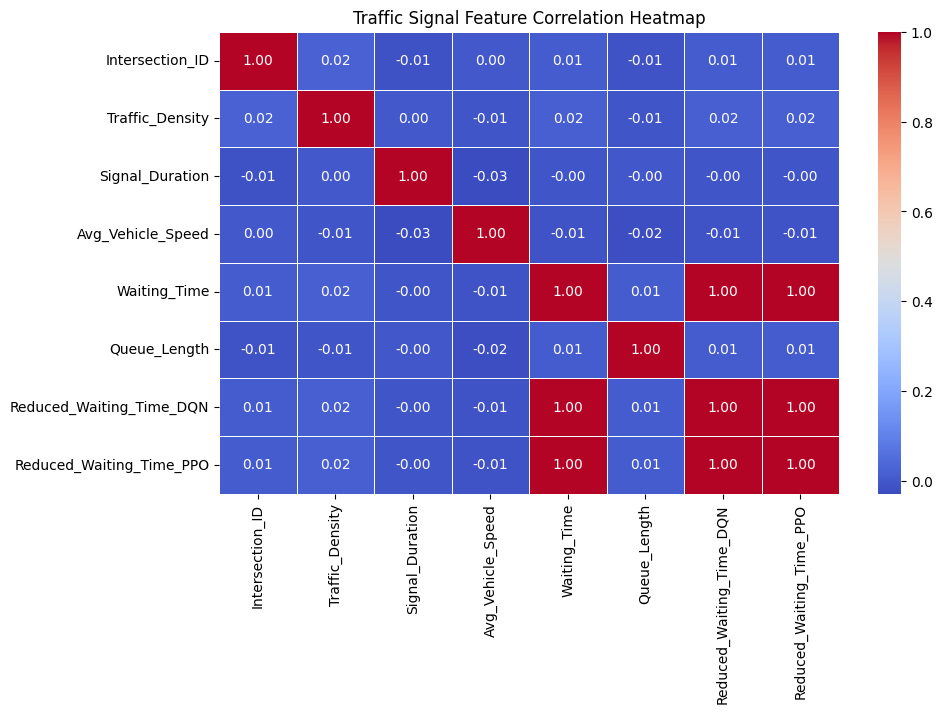

In [ ]:
# Optional: Display as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Traffic Signal Feature Correlation Heatmap")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

In [ ]:
df['traffic_congestion'] = 0  # Initialize column with 0
df.loc[(df['Traffic_Density'] > 80) & (df['Waiting_Time'] > 60), 'traffic_congestion'] = 1  # Set to 1 if congestion condition is met

In [ ]:
# Drop non-numeric columns and define features & target
df_numeric = df.select_dtypes(include=['number'])
X = df_numeric.drop(columns=['traffic_congestion'], errors='ignore')  # Features
y = df['traffic_congestion']  # Target


In [ ]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classification model (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

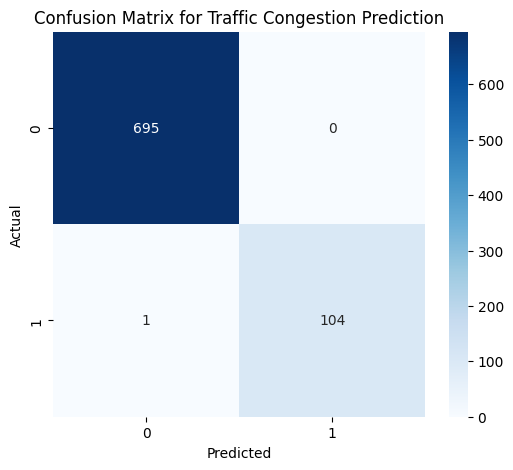

📊 **Classification Report:**
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       695
           1       1.00      0.99      1.00       105

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Traffic Congestion Prediction")
plt.show()

# Print classification report
print("📊 **Classification Report:**")
print(classification_report(y_test, y_pred))